## TUTTI I NODI VENGONO AL BURST
Il burst non ci permetteva di shiftare a piacemento i vagoni di impulsi.

Abbiamo impostato il trigger dell'awg sul canale sync (non più sul canale 2)
successivamente premendo su trigger abbiamo sincronizzato il trigger rispetto al canale 1 (Sync src ---> CH1,  sync ---> ON)


In [17]:
%reload_ext autoreload
%autoreload 2

In [45]:
%matplotlib widget
import pyvisa
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.optimize import curve_fit


import sys 
sys.path.insert(0, r'C:\Users\oper\SynologyDrive\Lab2023\Qubit\QTLab2324\PAandQubit\Actual_Work')
sys.path.insert(1, r'C:\Users\oper\SynologyDrive\Lab2023\Qubit\QTLab2324\PAandQubit\Instruments\network\RS_Signal_Generator')

sys.path.insert(2, r'C:\Users\oper\SynologyDrive\Lab2023\Qubit\QTLab2324\PAandQubit\Instruments\QuickSyn')
sys.path.insert(3, r'C:\Users\oper\SynologyDrive\Lab2023\Qubit\QTLab2324\PAandQubit\Instruments\Acquisition_Card')
sys.path.insert(4, r'C:\Users\oper\SynologyDrive\Lab2023\Qubit\QTLab2324\PAandQubit\Instruments\network\AWG')

import FunFit as FF
import Tuls as Ts


import RS_SMA100B
from AWG_KS_33500B import KS_33500B
import FSL_0010
from Card_Class import PXIe5170R

QSyn_port       = 'COM37'
SG_ip           = '192.168.40.15'                                  
Card_Name       = 'PXI1Slot3'

fsl             = FSL_0010.FSL10_synthesizer(device_address = QSyn_port)
sGen            = RS_SMA100B.SMA100B(ip = SG_ip)
augh            = KS_33500B()
pxie            = PXIe5170R(resource_name = Card_Name)


FSL_0010:	Connection successful!
SMA100B:	Connection successful!
AWG_KS33500B:	Connection successful!
PXIe_5170R:	Connection successful!


# ATTIVARE LA BURST MODE!!!

comando da remoto a pagina 141 di: https://www.keysight.com/it/en/assets/9018-03714/service-manuals/9018-03714.pdf?success=true#page=297&zoom=100,86,62

1 ciclo ?

trigger dal'awg e segnale (cioè i due canali) devono avere stesso periodo.

### BURST MODE
Resettavamo la fase (il delay) tra i due canali ma si settavano in maniera differente ad ogni refresh, seppur attuato senza cambiare alcun parametro dell'awg. Per ovviare a ciò, assicurarsi di attivare la burst mode.

In [46]:
# Signal Generator
sg_freq         = 5.729e9   # Hz
sg_level        = 8         # dBm
sg_period       = 100e-6    # s
sg_width        = 20e-6    # s
sg_delay        = 10e-6         # s
sg_pulse_mode   = 'SING'
sg_trig_mode    = 'ESIN'
sg_ref_freq     = 'EXT' # DA AGGIUNGERE ALLA LIBRERIA

# AWG - Signal
a1_freq         = 1e3       # Hz
a1_ampl         = 6         # dBm
a1_offset       = 400e-3    # V
a1_phase        = -40e-6   # s
a1_width        = 10e-6      # s
a1_fun          = 'PULS'

# AWG - Trigger
a2_freq         = a1_freq   # Hz
a2_ampl         = Ts.dBm_to_mVpp(8)         # Vpp
a2_offset       = 0         # V
a2_phase        = 0         # s
a2_width        = 25e-6     # s
a2_fun          = 'PULS'

In [51]:
# QuickSyn
qs_freq         = sg_freq + 10e3
fsl.set_frequency(qs_freq)
fsl.set_ref_source('INT')
fsl.set_output('ON')
fsl.set_ref_out('ON')

augh.ref_10MHz_src('EXT')

In [52]:
sGen.RF_freq(sg_freq)
sGen.RF_lvl_ampl(sg_level)
sGen.pul_gen_mode(sg_pulse_mode)
sGen.pul_trig_mode(sg_trig_mode)
sGen.pul_gen_params(period = sg_period, delay = sg_delay, width = sg_width)
sGen.pul_state(1)
sGen.RF_state(1)
# sGen.ref

augh.set_amplitude(a1_ampl, 'DBM', 1)
augh.set_waveform(freq = a1_freq, ampl = a1_ampl, offs = a1_offset, fun = a1_fun, ch = 1, width = a1_width)
augh.set_phase(a1_phase, unit = 'SEC', ch = 1)

# augh.set_phase(a2_phase, ch = 2,  unit = 'SEC')
# augh.set_waveform(freq = a2_freq, ampl = a2_ampl, offs = a2_offset, fun = a2_fun, ch = 2, width = a2_width)

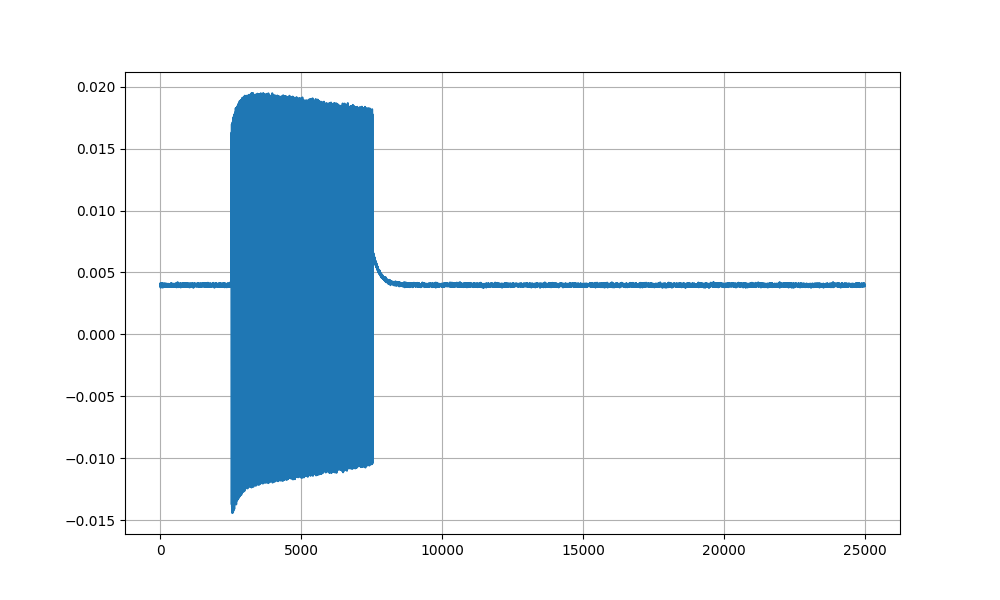

In [53]:
pxie.num_pts            = 25000
pxie.sample_rate        = 250e6 
pxie.num_records        = 100

sGen.pul_state(1)
sGen.RF_state(1)

pxie.coupling = 'AC'
pxie.voltage_range = 3
pxie.open(trigger_channel = '3')
waveforms = pxie.acquisition()

I = np.mean(waveforms['CH0'], axis=0)
# mod = 5*np.log10(Q**2 + I**2)



plt.figure(figsize=(10,6))
plt.grid()
plt.plot(I)
plt.show()

In [ ]:
# frequency = 5e9
# pulse_width = 4e-6
# awg_freq = 1e3
# SG_level = -15
# sGen.RF_freq(frequency)
# sGen.RF_lvl_ampl(SG_level)
# fsl.set_frequency(frequency)

# fsl.set_output('ON')
# sGen.pul_gen_mode('SING')
# sGen.pul_trig_mode('ESIN')
# sGen.pul_gen_params(pulse_width, delay = 0, width = pulse_width)
# sGen.pul_state(1)
# sGen.RF_state(1)





# aug_pow = Ts.dBm_to_mVpp(-40 - 10)*1e-3

# phase = -5e-6                        # in gradiants
# augh.set_phase(phase, ch = 1,  unit = 'SEC')
# augh.set_waveform( freq = 1e3, ampl = aug_pow, offs = 0.417, fun = 'PULS', ch = 1, width = 5e-6)

## Cosa abbiamo fatto:
Lo scopo di oggi 26/06/2024 è stato quello di trovare il delay relativo per l'impulso di drive e di read out e anche l'offset di dell' awg.

## Parametri strumenti
Da canale 1 di Awg mandiamo 800 mVpp, offset di 400 mV, fase 33° e larghezza di 4 micros. Suo segnale e trigger sono a 2 kHz. Il Trigger (Nel canale 2) è a 1 Vpp e la sua larghezza è di 200 microsecondi.

Sfasamento tra awg e Sig_Gen = -1.8°

impostazione trigger del sig gen: trigger Mode = Ext Single

Che cazzo è precisamente sto offset?

In [ ]:
fsl.set_output('ON')
fsl.set_frequency(5e9)
fsl.set_ref_source('INT')
fsl.set_ref_out('ON')
fsl.get_ref_out()

'Ref out: ON\n'